In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

In [123]:
###################################################################
# Plot options
###################################################################
font = {'family' : 'serif',
        'serif'   : 'palatino',
        #'sans-serif'    : 'Computer Modern Sans serif',
        'style'   : 'normal',
        'variant'   : 'normal',
        'stretch'   : 'normal',
        'weight'   : 'normal',
        'size'   : 9}
plt.rc('font', **font)
plt.rc('text', usetex=True)
#plt.rcParams['figure.figsize'] = (3.37,2.25)
plt.rcParams['figure.figsize'] = (6.72,3)


In [101]:
palette=plt.rcParams['axes.prop_cycle'].by_key()['color']

# Multilambda

In [134]:
molecules=384
kT=3.68328364 #kJ/mol

In [135]:
dataml=np.genfromtxt("COLVAR")

In [150]:
time=dataml[:,0]
enewat=dataml[:,1]
enelj=dataml[:,2]
deltau=dataml[:,3]
bias=dataml[:,4]

In [103]:
def batch(data,total_batch_num,batch_num):
    """Make batches or blocks.

    Args:
        data (numpy array): Data
        total_batch_num (int): Total desired number of batches (blocks)
        batch_num (int): Number of the batch that will be returned

    Returns:
        numpy array: The selected batch of the data array
    """
    if (batch_num<0):
        raise Exception('batch_num must be greater than 0! Start from index 0')
    if (batch_num>(total_batch_num-1)):
        raise Exception('batch_num must be smaller than total_batch_num-1!')
    batch_size=int(data.shape[0]/total_batch_num)
    start=batch_size*batch_num
    end=batch_size*(batch_num+1)
    if (end>data.shape[0] or batch_num==(total_batch_num-1)):
        end=data.shape[0]
    return data[start:end]

In [104]:
def averageBatch(values,weights,total_batch_num):
    """Find the weighted average of some quantity in batches

    Args:
        values (numpy array): Data to be averages
        weights (numpy array): Weights
        total_batch_num (int): Total desired number of batches (blocks)

    Returns:
        numpy array: The weighted average of the data in each batch (block)
        numpy array: The weights of each batch (block)

    """
    valuesVector=np.zeros([total_batch_num])
    Z=np.zeros([total_batch_num])
    for k in range(total_batch_num):
        valuesVector[k]=np.average(batch(values,total_batch_num,k),weights=batch(weights,total_batch_num,k))
        Z[k]=np.sum(batch(weights,total_batch_num,k))
    return valuesVector, Z

In [105]:
def observableAvgBatch(observable,bias,temperature,total_batch_num):
    """Find the average in blocks of some observable that was sampled in a biased simulation.

    Args:
        observable (numpy array): Observable
        bias (numpy array): Bias potential in kJ/mol
        temperature (float): Temperature in K
        total_batch_num (int): Total desired number of batches (blocks)

    Returns:
        numpy array: The average of the observable in each batch (block)
        numpy array: The weights of each batch (block)

    """
    beta=1./(0.00831441001626*temperature)
    return averageBatch(observable,np.exp(beta*bias),total_batch_num)

In [106]:
def stdWithWeights(values, weights):
    """Calculate a standard deviation of observations with weights.

    Args:
        values (numpy array): Data
        weights (numpy array): Weights

    Returns:
        float: Standard deviation
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    N=float(values.shape[0])
    return np.sqrt(variance*N/(N-1))

In [180]:
# Calculate integrand and error
mylambda=np.linspace(0,1,1000)
integrand=np.zeros(mylambda.shape[0])
ignore=20000
N=10 # batches
stddevintegrand=np.zeros(mylambda.shape[0])
neff=np.zeros(mylambda.shape[0])
temperature=443
beta=1./(0.00831441001626*temperature)
for i in range(mylambda.shape[0]):
    totalbias=bias[ignore:]+mylambda[i]*(-deltau[ignore:])
    totalbias -= np.mean(totalbias) + 1000
    avg=np.zeros(N)
    weights=np.zeros(N)
    avg, weights = observableAvgBatch(deltau[ignore:]/(kT*molecules),totalbias,temperature,N)
    integrand[i], dummy = observableAvgBatch(deltau[ignore:]/(kT*molecules),totalbias,temperature,1)
    stddevintegrand[i]=stdWithWeights(avg,weights)/np.sqrt(N)
    norm = np.sum(np.exp(beta*totalbias))
    weights2 = np.sum(np.power(np.exp(beta*totalbias)/norm,2))
    neff[i]=1/weights2

6.996417425132498


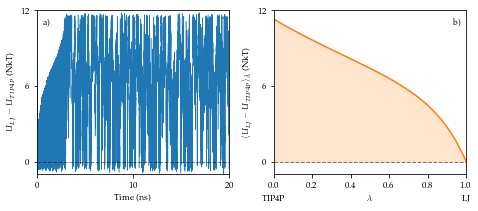

In [186]:
f, (ax1, ax2) = plt.subplots(1,2) #, sharey=True)

ax2.plot(mylambda,integrand,c=palette[1],zorder=0,label="multilambda")
# Error too small to be plotter
#ax2.errorbar(mylambda[::10],integrand[::10],stddevintegrand[::10],c=palette[1],zorder=1)
ax2.fill_between(mylambda,integrand,0,alpha=0.2,color=palette[1])
print(integrate.simps(integrand,x=mylambda))
ax2.set_xlabel(r'$\lambda$')
ax2.set_xlim([0,1])
ax2.plot([0,1],[0,0],'--',color='black',alpha=0.5,linewidth=1)
ax2.set_ylabel(r'$\langle U_{LJ} - U_{TIP4P} \rangle_{\lambda}$ (NkT)')
ax2.set_ylim([-1,12])
ax2.set_yticks([0,6,12])
ax2.text(0.0,-3,'TIP4P',ha='center',va='center')
ax2.text(1.0,-3,'LJ',ha='center',va='center')
ax2.text(0.95,11,'b)',ha='center',va='center')

ax1.plot((time-time[0])/1000,deltau/(kT*molecules),color=palette[0],linewidth=0.5)
ax1.set_xlim([0,20])
ax1.set_xticks([0,10,20])
ax1.plot([0,20],[0,0],'--',color='black',alpha=0.5,linewidth=1)
ax1.set_xlabel("Time (ns)")
ax1.set_ylim([-1,12])
ax1.set_yticks([0,6,12])
ax1.set_ylabel(r'$U_{LJ} - U_{TIP4P}$ (NkT)')
ax1.text(1.0,11,'a)',ha='center',va='center')

plt.tight_layout()

plt.savefig("Figure.pdf", bbox_inches='tight')

plt.show()

# Effective sample size

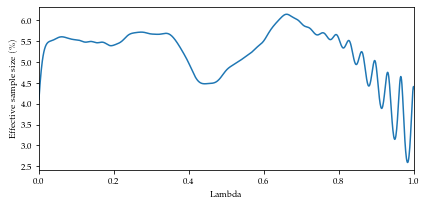

In [182]:
totalSamples=deltau[ignore:].shape[0]
plt.plot(mylambda,100*neff/totalSamples)
plt.xlabel("Lambda")
plt.ylabel(r'Effective sample size $(\%)$')
plt.xlim([0,1])
#plt.ylim([-12,0])
plt.show()